# Reinforcement Learning

We will look at CartPole-V0 which is already implemented as part of [gym](https://gym.openai.com/envs/#classic_control) and is a simple game of balancing a pole on a plate by moving the plate along a single axis. 

Our agent or NN has two components:
- Actor: Predicts the probability associated with each action (left or right) based on the state of the pole
- Critic: Estimates the rewards the agent will receive in the future.

We will use the rewards as the objective function to be maximized during training.


Based on this [example](https://keras.io/examples/rl/actor_critic_cartpole/) by A. Nandan.

## Setup

In [2]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration parameters for the whole setup
seed = 42
# Discount factor for past rewards
gamma = 0.99
# Number of steps before ending the session
max_steps_per_episode = 10000

# Create the environment
env = gym.make("CartPole-v0")
env.seed(seed)
# Smallest number such that 1.0 + eps != 1.0
eps = np.finfo(np.float32).eps.item()

In [7]:
num_inputs = 4
num_actions = 2
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
x = layers.Dense(128, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(x)
critic = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=[action, critic])

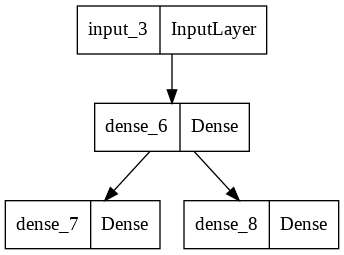

In [8]:
keras.utils.plot_model(model, to_file='ActionCritic.png')

## Training

In [25]:
# Reset the environment
state = env.reset()

In [26]:
# Feedforward
model(tf.convert_to_tensor([state]))

[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5000212 , 0.49997875]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01055172]], dtype=float32)>]

In [27]:
env.step(0)

(array([-0.01820141, -0.17833326,  0.02500666,  0.32754535]), 1.0, False, {})

In [30]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
# The loss function to use for the critic.
huber_loss = keras.losses.Huber()
# History of the feedforward passes.
action_probs_history = []
critic_value_history = []
# History of the rewards
rewards_history = []
running_reward = 0
episode_count = 0

# Run episodes until solved.
while True:
    # Reset the environment after each run.
    state = env.reset()
    episode_reward = 0

    with tf.GradientTape() as tape:
        # Runs a maximum of max_steps unless the game end prematurely.
        for timestep in range(1, max_steps_per_episode):
            # Convert the state to a tf tensor.
            state = tf.convert_to_tensor(state)
            # Add an extra dim: shape=(x) --> (1,x)
            state = tf.expand_dims(state, 0)

            # Feedforward: predicts probabilities for the next action as well as
            # the expected rewards.
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution:
            # action = 0 or 1 corresponds to the choice made, the log of the
            # associated probability is then added to action_probs_history.
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            # Actor loss:
            actor_losses.append(-log_prob * diff)

            # Critic loss:
            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break


running reward: 7.00 at episode 10
running reward: 10.95 at episode 20
running reward: 16.84 at episode 30
running reward: 19.53 at episode 40
running reward: 16.09 at episode 50
running reward: 14.41 at episode 60
running reward: 13.68 at episode 70
running reward: 13.86 at episode 80
running reward: 14.10 at episode 90
running reward: 16.07 at episode 100
running reward: 15.85 at episode 110
running reward: 15.74 at episode 120
running reward: 15.23 at episode 130
running reward: 16.86 at episode 140
running reward: 34.96 at episode 150
running reward: 25.52 at episode 160
running reward: 19.48 at episode 170
running reward: 15.66 at episode 180
running reward: 13.49 at episode 190
running reward: 11.98 at episode 200
running reward: 11.06 at episode 210
running reward: 10.33 at episode 220
running reward: 10.22 at episode 230
running reward: 10.06 at episode 240
running reward: 9.91 at episode 250
running reward: 9.80 at episode 260
running reward: 9.74 at episode 270
running reward

## Visualization
In early stages of training:

![Imgur](https://i.imgur.com/5gCs5kH.gif)

In later stages of training:

![Imgur](https://i.imgur.com/5ziiZUD.gif)
